<a href="https://colab.research.google.com/github/Nicolas-BZRD/VLille-prediction/blob/main/VLille_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#VLille Forecasting

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##0 - Convert dataset in a CSV format (optional)

In [3]:
# data = list()

In [4]:
# fields = ["stationID","stationName","address","city","status","type","geo","placesAvailable","bikes","connection","localisation","lastUpdate","weatherId","feelsLike","rain"]

# with open("/content/drive/MyDrive/Dataset/VLille/vlille_dataset.txt", 'r') as f:
#   lines = f.readlines()

#   for line in lines:
#     line = line.replace("\n", "")
    
#     if(line[:7] == "Weather"):
#       weather = line[9:-1].split(";")
#       if(len(weather) == 2): weather.append("0")
#     else:
#       dataRow = line.split(';') + weather
#       data.append(dataRow)

In [5]:
# with open('vlille_dataset.csv', 'w') as f:
#     write = csv.writer(f)
#     write.writerow(fields)
#     write.writerows(data)

##1 - Load and review the dataset

In [6]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/VLille/vlille_dataset.csv')
df.head()

,stationID,stationName,address,city,status,type,geo,placesAvailable,bikes,connection,localisation,lastUpdate,weatherId,feelsLike,rain
0,93.0,STADE BALLET,85 RUE DU LONG POT,LILLE,EN SERVICE,SANS TPE,"50.628918,3.088147",9.0,9.0,CONNECTED,"50.628918,3.088147",2022-02-05T14:00:22+01:00,803.0,280.66,0.0
1,140.0,RUE CORNEILLE,RUE CORNEILLE,VILLENEUVE D'ASCQ,EN SERVICE,AVEC TPE,"50.623795,3.144815",0.0,0.0,CONNECTED,"50.623795,3.144815",2019-10-17T16:37:06+02:00,803.0,280.66,0.0
2,55.0,PORTE D'ARRAS,3 PLACE JACQUES FEBVRIER,LILLE,EN SERVICE,AVEC TPE,"50.617847,3.061758",19.0,5.0,CONNECTED,"50.617847,3.061758",2022-02-05T14:00:22+01:00,803.0,280.66,0.0
3,129.0,FLERS CHATEAU,RUE DE LA CHEVALERIE,VILLENEUVE D'ASCQ,EN SERVICE,AVEC TPE,"50.63608,3.130853",0.0,0.0,CONNECTED,"50.63608,3.130853",2019-10-21T11:46:05+02:00,803.0,280.66,0.0
4,76.0,FIVES,123 RUE PIERRE LEGRAND,LILLE,EN SERVICE,AVEC TPE,"50.632996,3.089651",18.0,6.0,CONNECTED,"50.632996,3.089651",2022-02-05T14:00:22+01:00,803.0,280.66,0.0


###Review of the data set

In [7]:
df.describe()

,stationID,placesAvailable,bikes,weatherId,feelsLike,rain
count,296856.000000,296856.000000,296856.000000,296856.000000,296856.000000,296856.000000
mean,131.376984,10.299105,7.446755,780.432088,280.791231,0.042649
std,78.850231,6.932476,5.769639,78.217967,4.809462,0.227586
min,1.000000,0.000000,0.000000,300.000000,269.340000,0.000000
25%,63.750000,6.000000,3.000000,800.000000,277.750000,0.000000
50%,126.500000,10.000000,7.000000,801.000000,280.010000,0.000000
75%,205.250000,14.000000,11.000000,803.000000,283.950000,0.000000
max,299.000000,40.000000,40.000000,804.000000,292.510000,2.730000


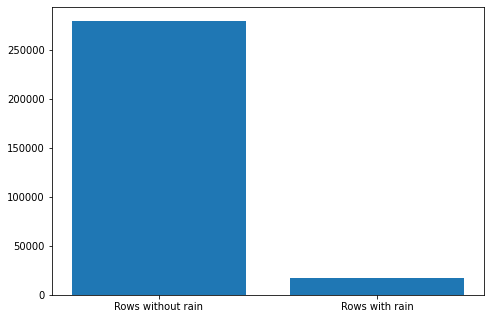

In [8]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['Rows without rain', 'Rows with rain']
values = [df['rain'].value_counts()[0.0], len(df.index)-df['rain'].value_counts()[0.0]]
ax.bar(labels,values)
plt.show()

**Remarqs:** The dataset is unbalanced with 94% of the lines with "good" weather and only 6% with rain. We can also see that feels like temperature have a very low standard deviation, so we need to scrap data this summer/winter to get a larger temperature sample.

**Funny remarqs:** For an average of 7 bikes, we have 10 spaces available, which means for example that if we have 100 bikes in total in Lille, we have 130 spaces. We can also see that the largest docking point can be completely empty or full.

##2 - Data processing

###Drop unnecessary rows

In [9]:
# Drop rows where the dowking point was disconnected.
df = df.drop(df[df.connection == "DISCONNECTED"].index)

# Drop rows that didn't have an "EN SERVICE" status.
df = df.drop(df[(df.status != "EN SERVICE")].index)

# Drop data that has not been updated recently.
df = df.drop(df[(df.lastUpdate.str.contains("2022") == False)].index)

###Normalization of some data like date or time.

Convert the lastUpdate column represented by a string object into a datetime object and float objects to int when it's possible.

In [10]:
df['lastUpdate'] = df['lastUpdate'].str[:-6]
df['lastUpdate'] = pd.to_datetime(df['lastUpdate'], format='%Y-%m-%dT%H:%M:%S')

df = df.astype({"placesAvailable":'int', "bikes":'int', "weatherId":'int'}) 

We add the weekday value to our dataset in order to simplify and generalize the model that we will implement (Monday: 0; Tuesday: 1 ; ...; Saturday: 5; Sunday: 6).<br><br>

We also add a column to store the time into a day segment (00h30: 1; 12h00: 24; 14h26: 28; ...; 23h59: 47).

In [11]:
df['weekday'] = df.apply(lambda x: x["lastUpdate"].weekday(), axis=1)
df['dayTime'] = df.apply(lambda x: int((x["lastUpdate"].hour*60+x["lastUpdate"].minute)/30), axis=1)

In [12]:
df.head()

,stationID,stationName,address,city,status,type,geo,placesAvailable,bikes,connection,localisation,lastUpdate,weatherId,feelsLike,rain,weekday,dayTime
0,93.0,STADE BALLET,85 RUE DU LONG POT,LILLE,EN SERVICE,SANS TPE,"50.628918,3.088147",9,9,CONNECTED,"50.628918,3.088147",2022-02-05 14:00:22,803,280.66,0.0,5,28
2,55.0,PORTE D'ARRAS,3 PLACE JACQUES FEBVRIER,LILLE,EN SERVICE,AVEC TPE,"50.617847,3.061758",19,5,CONNECTED,"50.617847,3.061758",2022-02-05 14:00:22,803,280.66,0.0,5,28
4,76.0,FIVES,123 RUE PIERRE LEGRAND,LILLE,EN SERVICE,AVEC TPE,"50.632996,3.089651",18,6,CONNECTED,"50.632996,3.089651",2022-02-05 14:00:22,803,280.66,0.0,5,28
5,71.0,BOIS BLANCS,122 AVENUE DE DUNKERQUE,LILLE,EN SERVICE,AVEC TPE,"50.634045,3.030778",9,13,CONNECTED,"50.634045,3.030778",2022-02-05 14:00:22,803,280.66,0.0,5,28
6,111.0,HELLEMMES CIMETIERE,"318, RUE ROGER SALENGRO",HELLEMMES,EN SERVICE,SANS TPE,"50.62486,3.116677",6,6,CONNECTED,"50.62486,3.116677",2022-02-05 14:00:22,803,280.66,0.0,5,28


##3 - AI

###Random forest

Creation X, Y (features: stationID, weatherID, feelsLike, rain, weekday, dayTime / output: bikes)

In [13]:
X = df[['stationID','weatherId','feelsLike','rain','weekday','dayTime']].to_numpy()
Y = df['bikes'].to_numpy()

Creation of the model.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

rf = RandomForestRegressor(random_state = 2)
rf.fit(X_train, y_train)

print("Accuracy: %f\n\nIMPORTANCES OF EACH FEATURES:" % rf.score(X_test, y_test))
for idx, x in enumerate(['stationID','weatherId','feelsLike','rain','weekday','dayTime']):
    print(x, " : ", rf.feature_importances_[idx])

Accuracy: 0.774433

IMPORTANCES OF EACH FEATURES:
stationID  :  0.43098184260040284
weatherId  :  0.05697185884498039
feelsLike  :  0.19406424597229455
rain  :  0.006843155202603615
weekday  :  0.13786509561645785
dayTime  :  0.1732738017632608


Graph showing the value of the predicted bikes compared to the desired values.

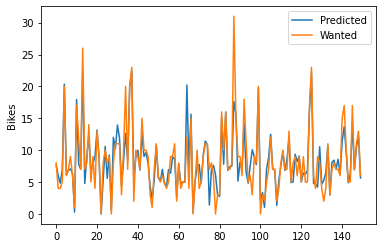

In [29]:
size = 150
x = np.arange(size)
  
plt.plot(x, rf.predict(X_test)[0:size], label = "Predicted")
plt.plot(x, y_test[0:size], label = "Wanted")
plt.legend()
plt.ylabel("Bikes")
plt.show()